In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_torch(2023)

In [3]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)





            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [4]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230307_144157/20230307_144157/BestF1_0.pt'
save_root = Models_path[:-3]+'/'
layervalue_root = save_root+'/layervalue/'
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
criterion = torch.nn.CrossEntropyLoss()
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path))
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

## 计算出最佳阈值，并获得该阈值下的y_pred

In [5]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
def ROC(label, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param label: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_th, optimal_point
    """
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(label, y_prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point

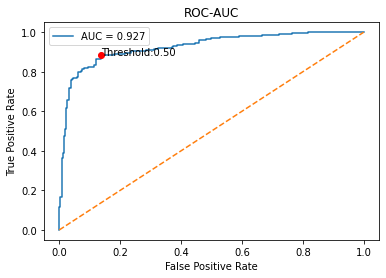

[[227  36]
 [ 32 239]]


In [6]:
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(y_true,((np.array(y_out))[:,1]))
plt.figure(1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
CM = confusion_matrix(y_true,y_pred)
print(CM)
y_pred = ((np.array(y_out))[:,1])
y_pred[y_pred>optimal_th] =  int(1)
y_pred[y_pred<=optimal_th] =  int(0)

## 获取特征

In [7]:
def calculate_area(ECG:np.array,start_index:np.array,end_index:np.array): # type: ignore 
    p_area = 0
    for lead in range(12):
        for bet in range(len(start_index)):
            start = int(start_index[bet])
            end = int(end_index[bet])
            p_area = p_area + ((ECG[lead,start:end] - ECG[lead,start:end].min()).sum())/(end-start)
    p_area = p_area/((len(start_index)))
    return p_area

In [8]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'

lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Amplitude_name_list = []
for i in range(12):
    Amplitude_name_list.append('P_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('Q_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('R_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('S_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('T_Amplitude_'+lead_index[i])
Amplitude_features_12leads =    pd.DataFrame(columns=Amplitude_name_list)
Timing_features = pd.DataFrame(columns=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval','P_area'])

for index in range(test_dataset.__len__()):#test_dataset.__len__()
    info =test_dataset.infos.iloc[index]
    ECG,_ = test_dataset.__getitem__(index)
    ECGfile_name = info['ECGFilename']
    layervalue_file = layervalue_root  + ECGfile_name +'.npy'
    
    FPT = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
    Timing_feature_sync = np.load(waves_location_file_root+'/Timing_feature_sync/'+ECGfile_name+'.npy')
    Amplitude_feature_12leads = np.load(waves_location_file_root+'/Amplitude_feature_12leads/'+ECGfile_name+'.npy')
    
    Amplitude_feature_12leads = pd.DataFrame((Amplitude_feature_12leads.transpose(1,0,2)[1:-1]).reshape(-1,60),columns=Amplitude_name_list) #lead,bet,5 -> bet,lead,5 ->bet,lead*5 
    FPT = pd.DataFrame(FPT[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','res0','T_start', 'T_peak', 'T_end','res0'])
    Timing_feature_sync = pd.DataFrame(Timing_feature_sync[1:-1],columns=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval'])
    
    
    Timing_feature = Timing_feature_sync.div(Timing_feature_sync['RR_interval'],axis=0) #(bet,13)把每个间隔除以每个RR间期
    Timing_feature['RR_interval'] = Timing_feature_sync['RR_interval']#恢复RR间期
    Timing_feature = Timing_feature.mean()
    Timing_feature['P_area'] = calculate_area(np.array(ECG),np.array(FPT['P_start']),np.array(FPT['P_end']))

    Amplitude_feature = Amplitude_feature_12leads.mean()
    
    Amplitude_features_12leads = Amplitude_features_12leads.append(Amplitude_feature,True)
    Timing_features = Timing_features.append(Timing_feature,True )
    
Amplitude_features_12leads = Amplitude_features_12leads.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))  #各个列归一化
Timing_features = Timing_features.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))  #各个列归一化

Amplitude_features_12leads.insert(0,'ECGFilename',test_dataset.infos['ECGFilename'].values)
Amplitude_features_12leads.insert(0,'label',test_dataset.infos['label'].values)
Amplitude_features_12leads.insert(0,'pred',y_pred)

Timing_features.insert(0,'ECGFilename',test_dataset.infos['ECGFilename'].values)
Timing_features.insert(0,'label',test_dataset.infos['label'].values)
Timing_features.insert(0,'pred',y_pred)

Amplitude_features_12leads["label"].replace(1,'HTN',inplace = True)
Amplitude_features_12leads["label"].replace(0,'NHTN',inplace = True)
Amplitude_features_12leads["pred"].replace(1,'HTN',inplace = True)
Amplitude_features_12leads["pred"].replace(0,'NHTN',inplace = True)
Timing_features["label"].replace(1,'HTN',inplace = True)
Timing_features["label"].replace(0,'NHTN',inplace = True)
Timing_features["pred"].replace(1,'HTN',inplace = True)
Timing_features["pred"].replace(0,'NHTN',inplace = True)


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


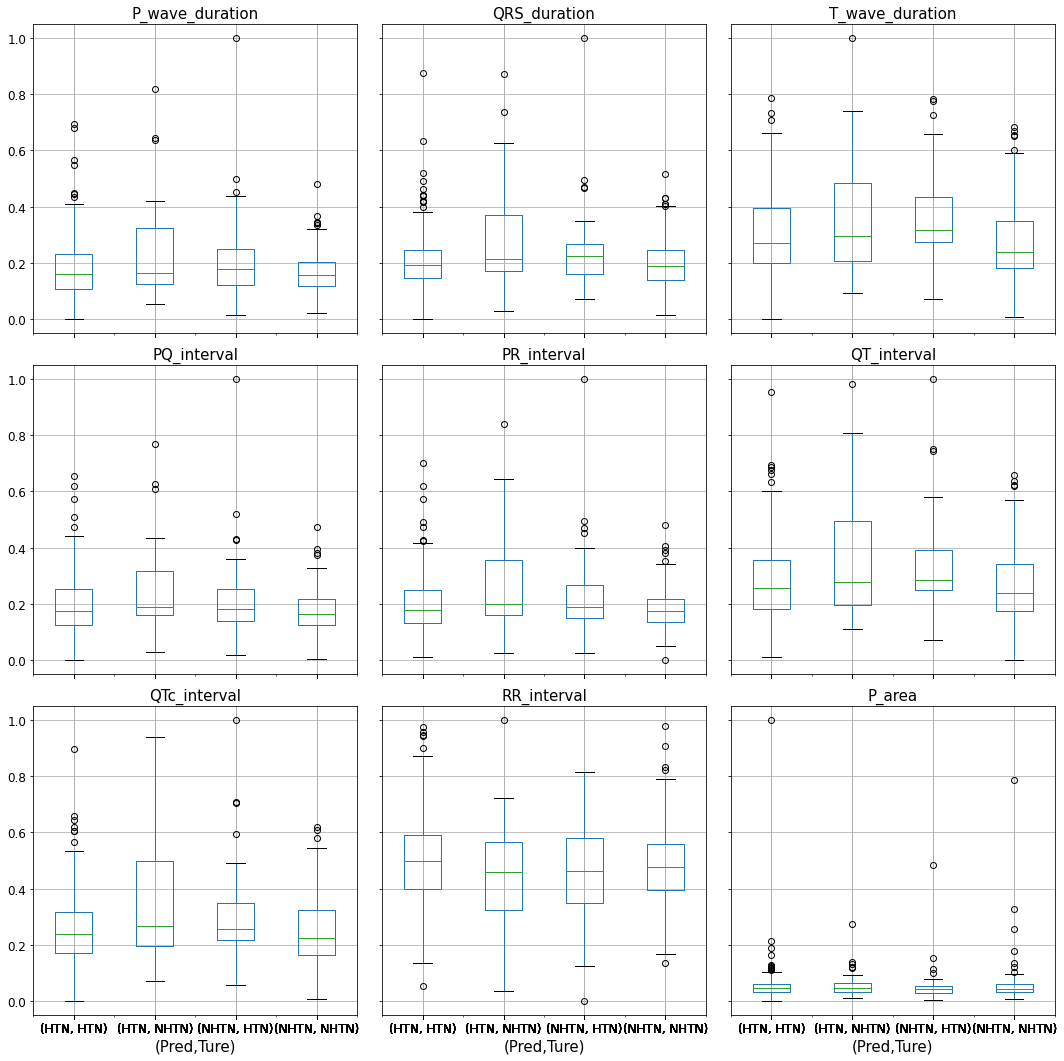

In [13]:
fig,axs=plt.subplots(layout='tight',figsize=(15,15))
Timing_features_name_list = ['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval','P_area']
boxplot = Timing_features.boxplot(column=Timing_features_name_list,by=['pred','label'],figsize=(25,25),fontsize=12,return_type='axes',ax = axs)
i = 0
for ax in boxplot:
     ax.set_title(Timing_features_name_list[i],fontsize=15)
     ax.set_xlabel('(Pred,Ture)',fontsize=15)
     i = i+1
fig.suptitle('')# 设置主标题
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


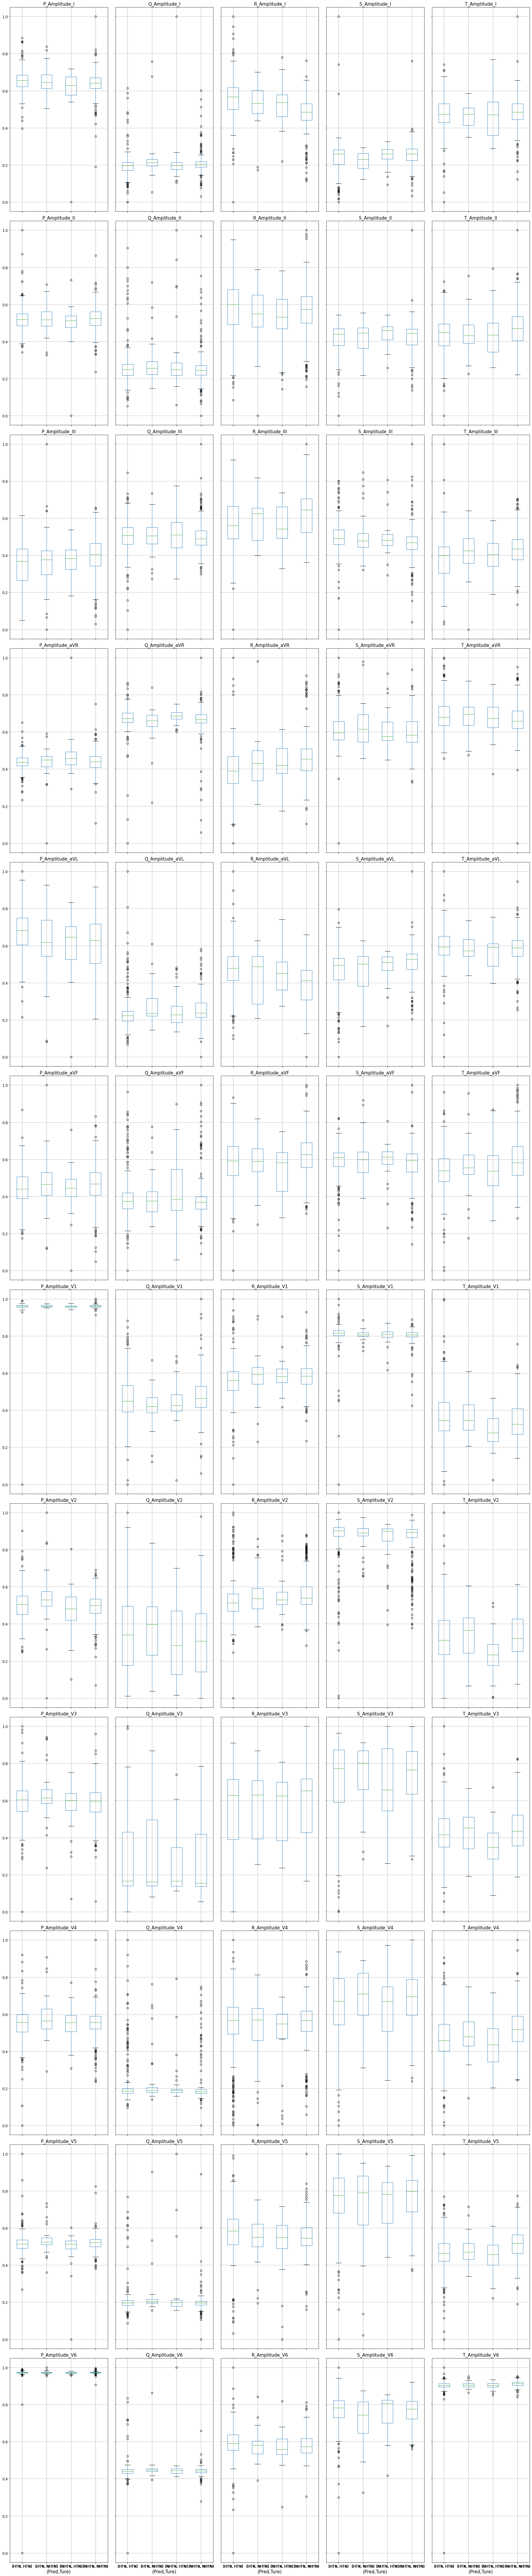

In [14]:
fig,axs=plt.subplots(layout='tight',figsize=(25,120))
Amplitude_features_12leads_list = []
boxplot = Amplitude_features_12leads.boxplot(column=Amplitude_name_list,by=['pred','label'],layout=(12,5),figsize=(25,120),fontsize=12,return_type='axes',ax = axs)
i = 0
for ax in boxplot:
     ax.set_title(Amplitude_name_list[i],fontsize=15)
     ax.set_xlabel('(Pred,Ture)',fontsize=15)
     i = i+1
fig.suptitle('')# 设置主标题
plt.show()

## 获取心拍波形

In [219]:
from scipy import interpolate

def segement_upsample(segement:np.ndarray,segement_num:int = 10):
    chanle_num = segement.shape[0]
    segement = torch.DoubleTensor(segement).unsqueeze(0).unsqueeze(0)# type: ignore    
    upsampler = nn.Upsample(size=(chanle_num,segement_num),  mode='bilinear',align_corners=False)
    segement_upsampled = upsampler(segement)
    return np.array(segement_upsampled.squeeze(0).squeeze(0))
    
def leads_layervalue_segement_count_upsample(start_index:int,end_index:int,layervalue:np.ndarray,segement_num:int = 10):
    len_ = end_index-start_index
    if(len_<=0):
        print('err')
        return 0
    chanle_num = layervalue.shape[0]
    layervalue_sum = np.zeros([chanle_num,segement_num])
    if(len_<segement_num): #如果长度小于需要分割的长度的话，需要上采样
        # print((layervalue[:,start_index:end_index]))
        segement_value = segement_upsample(layervalue[:,start_index:end_index],segement_num)#插值成segement_num步
        # print((segement_value))
        return segement_value
        
    else:
        step = len_//segement_num
        for i in range(segement_num):
            start = start_index+step*i
            sum_sement = layervalue[:,start:(start+step)].sum(axis = 1)/(step*1.0)
            layervalue_sum[:,i] = sum_sement*1. #在这一段step里面，每个时间点的平均重要程度
        return layervalue_sum
    
def leads_layervalue_segement_count(start_index:int,end_index:int,layervalue:np.ndarray,segement_num:int = 10):
    len_ = end_index-start_index
    if(len_<=0):
        print('err')
        return 0
    chanle_num = layervalue.shape[0]
    layervalue_sum = np.zeros([chanle_num,segement_num])
    if(len_<segement_num): #如果长度小于需要分割的长度的话，就取每一导联的平均值
        for i in range(segement_num):
           layervalue_sum[:,i] = layervalue_sum[:,i] + ((layervalue[:,start_index:end_index].sum(axis = 1))/(segement_num*1.0)) #返回每一导联的平均值，广播效应
        return layervalue_sum
    else:
        step = len_//segement_num
        for i in range(segement_num):
            start = start_index+step*i
            sum_sement = layervalue[:,start:(start+step)].sum(axis = 1)/(chanle_num*step*1.0)
            layervalue_sum[:,i] = layervalue_sum[:,i]+sum_sement*1. #在这一段step里面，每个时间点的平均重要程度
        return layervalue_sum
    
def max_min(x):
    max_ = x.max()
    min_ = x.min()
    x_ = (x-min_)/(max_-min_+1e-8)
    return x_

In [230]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'
select_list =['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','T_start', 'T_peak', 'T_end']
segement_num = 20 # 共6个片段，每段划分成10份

important_values = np.zeros([len(select_list)-1,12,segement_num]) #
ECG_values = np.zeros([len(select_list)-1,12,segement_num])

sample_count = 0
for index in range(test_dataset.__len__()):#test_dataset.__len__()
   
    important_value = np.zeros([len(select_list)-1,12,segement_num])
    ECG_value = np.zeros([len(select_list)-1,12,segement_num])
    
    info =test_dataset.infos.iloc[index]
    ECG,labels = test_dataset.__getitem__(index)
    
    if(labels != y_true[index]): 
        break
    pred = y_pred[index]
    if(((pred == labels) and (pred == 1))): 
        
        ECGfile_name = info['ECGFilename']
        layervalue_file = layervalue_root  + ECGfile_name +'.npy'
        waves = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
        layervalue = np.load(layervalue_file)
        waves_ = pd.DataFrame(waves[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','J','T_start', 'T_peak', 'T_end','res0'])
        waves = waves_[select_list].copy()
        if(waves.isnull().any().any()):
            continue
        for bet in range(len(waves.index)):
            for peak in range(len(waves.columns)-1):
                start = int(waves.loc[bet][peak])
                end = int(waves.loc[bet][peak+1])
                if (start >= end): continue
                important_value[peak] = important_value[peak] + leads_layervalue_segement_count_upsample(start,end,layervalue,segement_num)
                ECG_value[peak] = ECG_value[peak]+ leads_layervalue_segement_count_upsample(start,end,np.array(ECG),segement_num)
                
        ECG_value = ECG_value/len(waves.index)#按心拍数平均一下 
        ECG_value = max_min(ECG_value) 
        ECG_values = ECG_values +ECG_value
    
        important_value = important_value/len(waves.index)#按心拍数平均一下
        important_value = max_min(important_value) 
        important_values = important_values + important_value
        sample_count = sample_count +1
HTN_important_values = important_values/sample_count #按样本数平均一下
HTN_ECG_values = ECG_values/sample_count
print(sample_count)
        
        
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'
select_list =['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','T_start', 'T_peak', 'T_end']
segement_num = 20 # 共6个片段，每段划分成10份

important_values = np.zeros([len(select_list)-1,12,segement_num]) #
ECG_values = np.zeros([len(select_list)-1,12,segement_num])

sample_count = 0
for index in range(test_dataset.__len__()):#test_dataset.__len__()
   
    important_value = np.zeros([len(select_list)-1,12,segement_num])
    ECG_value = np.zeros([len(select_list)-1,12,segement_num])
    
    info =test_dataset.infos.iloc[index]
    ECG,labels = test_dataset.__getitem__(index)
    
    if(labels != y_true[index]): 
        break
    pred = y_pred[index]
    if(((pred == labels) and (pred == 0))): 
        
        ECGfile_name = info['ECGFilename']
        layervalue_file = layervalue_root  + ECGfile_name +'.npy'
        waves = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
        layervalue = np.load(layervalue_file)
        waves_ = pd.DataFrame(waves[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','J','T_start', 'T_peak', 'T_end','res0'])
        waves = waves_[select_list].copy()
        if(waves.isnull().any().any()):
            continue
        for bet in range(len(waves.index)):
            for peak in range(len(waves.columns)-1):
                start = int(waves.loc[bet][peak])
                end = int(waves.loc[bet][peak+1])
                if (start >= end): continue
                important_value[peak] = important_value[peak] + leads_layervalue_segement_count_upsample(start,end,layervalue,segement_num)
                ECG_value[peak] = ECG_value[peak]+ leads_layervalue_segement_count_upsample(start,end,np.array(ECG),segement_num)
                
        ECG_value = ECG_value/len(waves.index)#按心拍数平均一下 
        ECG_value = max_min(ECG_value) 
        ECG_values = ECG_values +ECG_value
    
        important_value = important_value/len(waves.index)#按心拍数平均一下
        important_value = max_min(important_value) 
        important_values = important_values + important_value
        sample_count = sample_count +1
NHTN_important_values = important_values/sample_count #按样本数平均一下
NHTN_ECG_values = ECG_values/sample_count
print(sample_count)
        
        

239
227


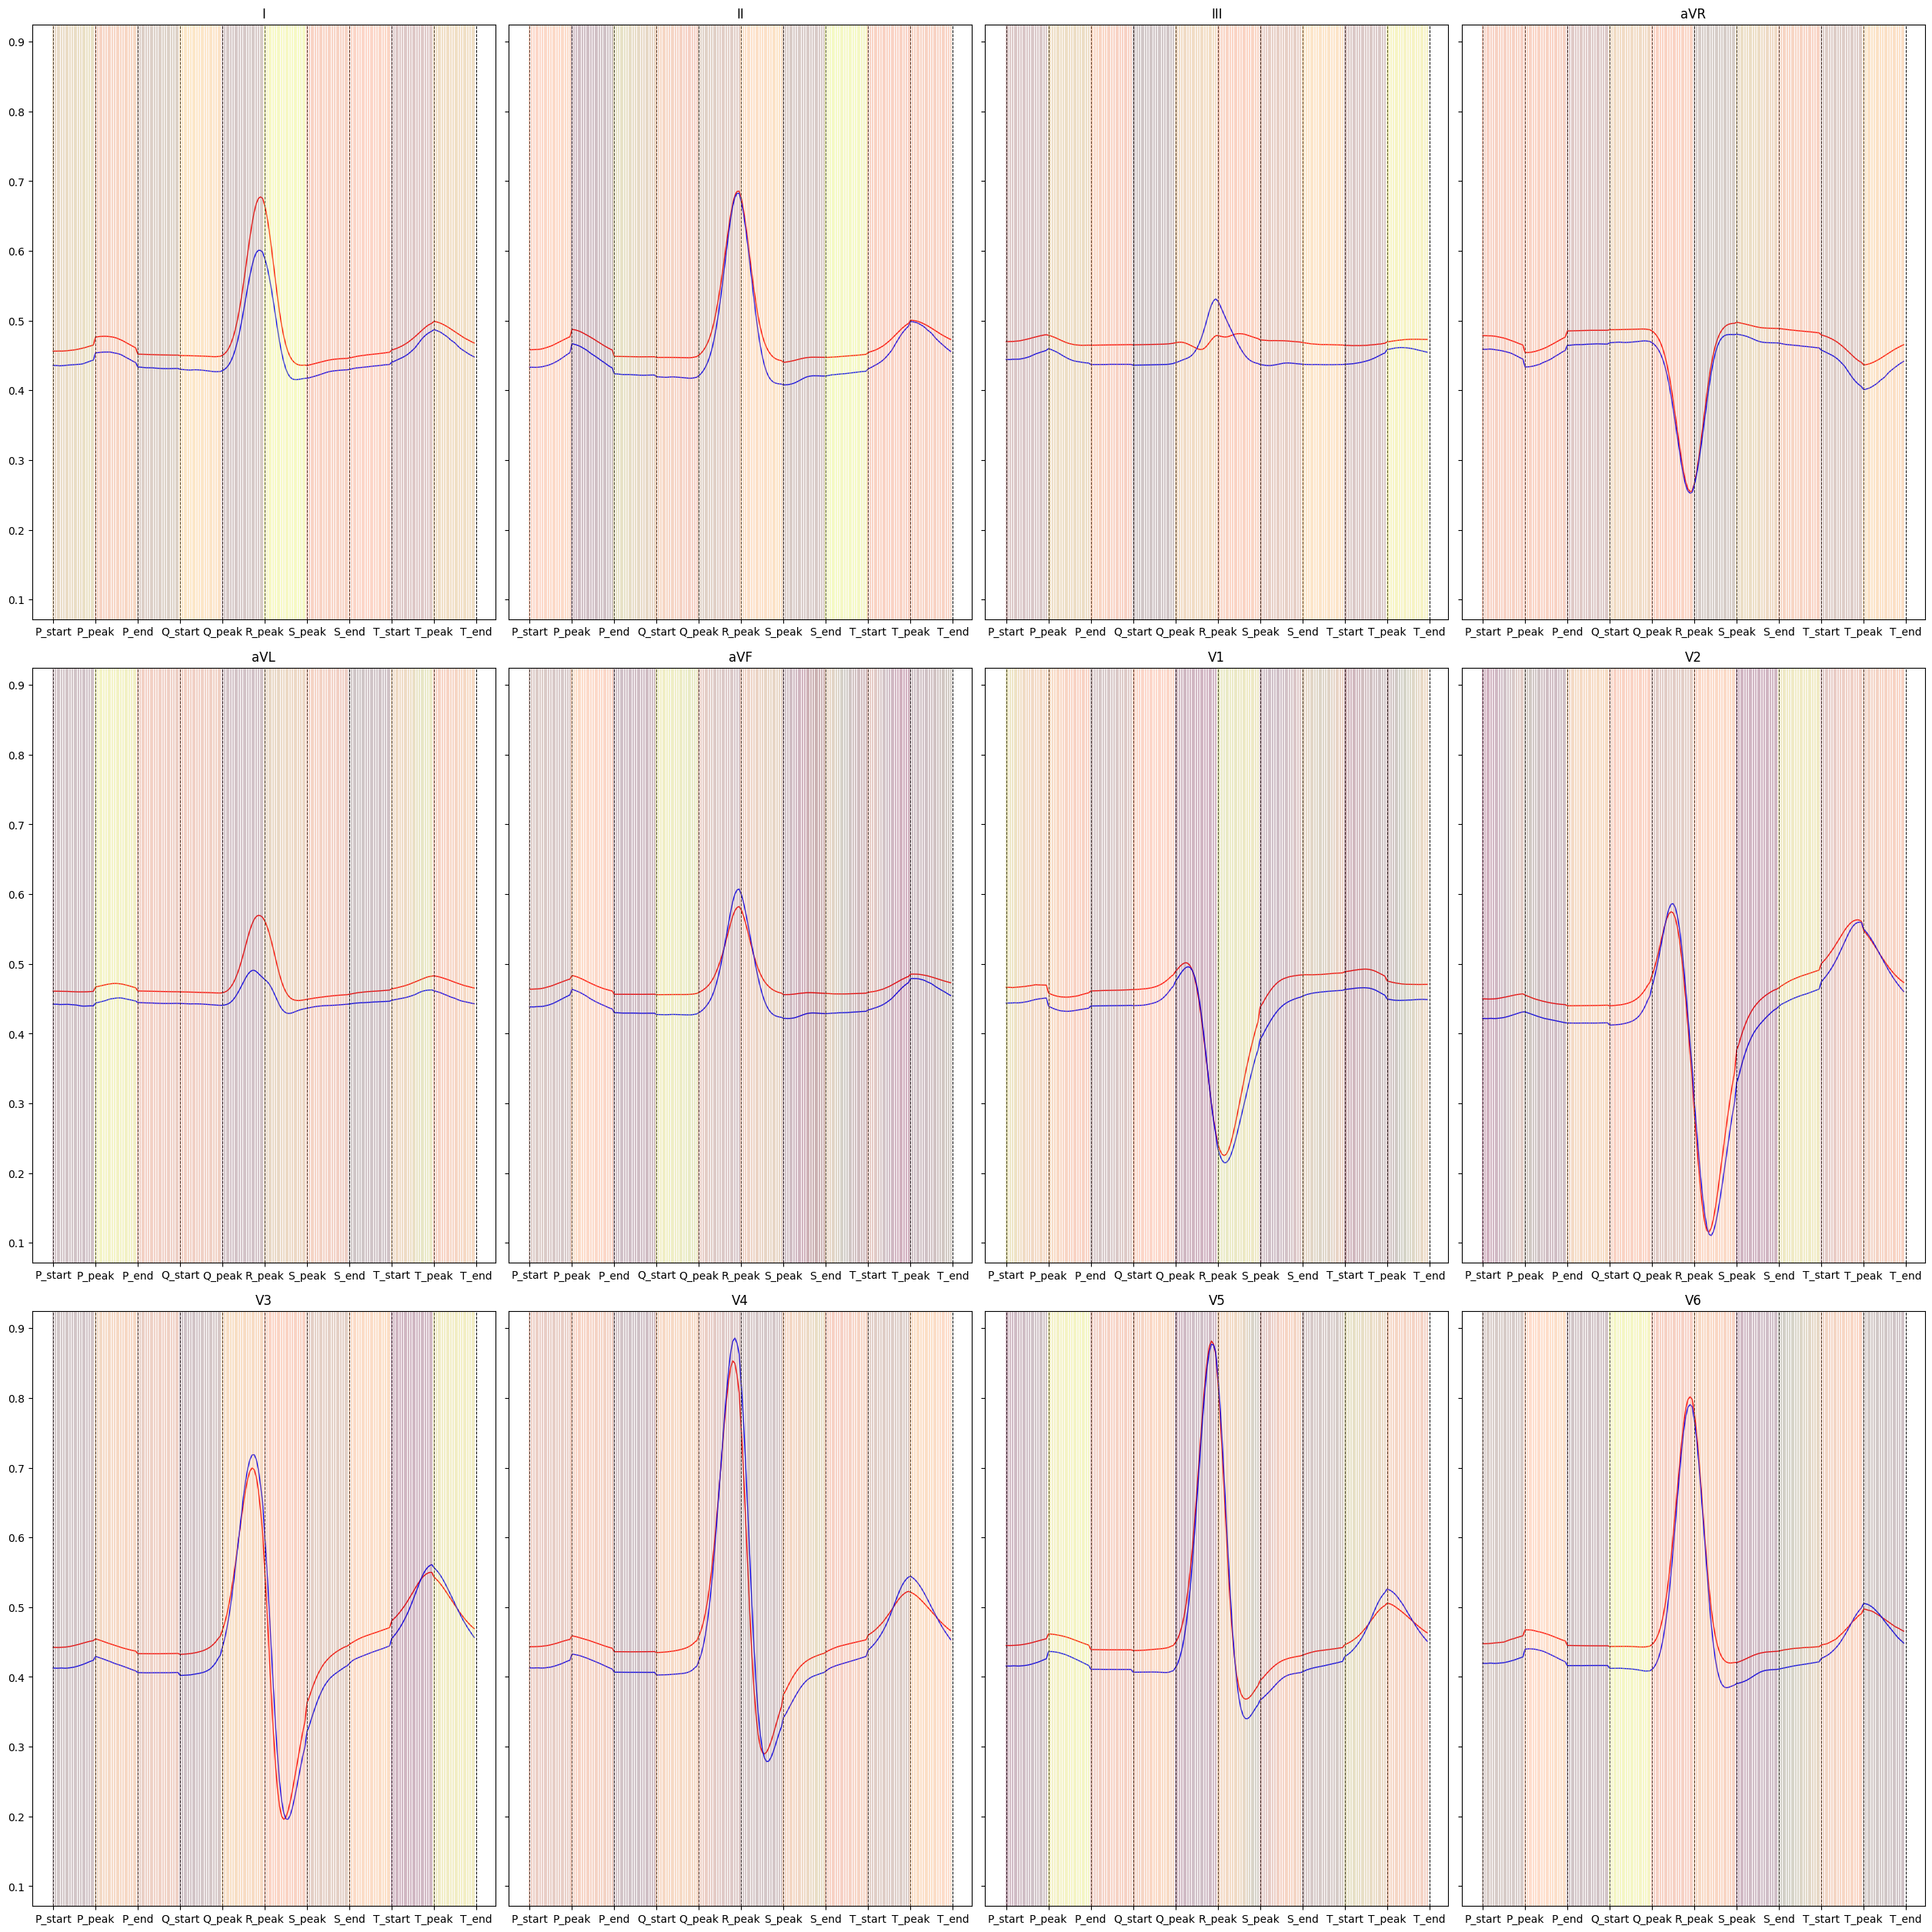

In [231]:
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
xticks_list = list(np.arange(0,len(select_list)*segement_num,segement_num))

fig, axs = plt.subplots(nrows=3, ncols=4,sharey=True,figsize=(25,25), constrained_layout=True,dpi =100)

HTN_colors = ECGplot.color_map(((HTN_important_values.reshape([12,-1]))), 'autumn')#相当于归一化
NHTN_colors = ECGplot.color_map(((NHTN_important_values.reshape([12,-1]))), 'YlGnBu')#相当于归一化
for i,ax in enumerate(axs.flat):  # type: ignore
    HTN_plot_y = np.array(HTN_ECG_values[:,i,:].flatten())
    HTN_colors_z = np.array(HTN_important_values[:,i,:].flatten())
    NHTN_plot_y = np.array(NHTN_ECG_values[:,i,:].flatten())
    NHTN_colors_z = np.array(NHTN_important_values[:,i,:].flatten())    
    t = np.arange(0,HTN_plot_y.shape[0]) #  
    ax.plot(t, (HTN_plot_y), lw=1,color='r')
    ax.plot(t, (NHTN_plot_y), lw=1,color='b')
    
    for j in range(len(select_list)):
        ax.axvline(x=int(xticks_list[j]),ls='dashed',lw=0.7,color='k')
        
    ax.set_xticks(xticks_list) # 设置刻度
    ax.set_xticklabels(select_list)
    ax.set_title(lead_index[i])
    for k in t:
        ax.axvline(x=k,alpha=0.2,color=HTN_colors[i,k]) #第i导联 第j个时间点的importance value
        ax.axvline(x=k,alpha=0.2,color=NHTN_colors[i,k]) #第i导联 第j个时间点的importance value

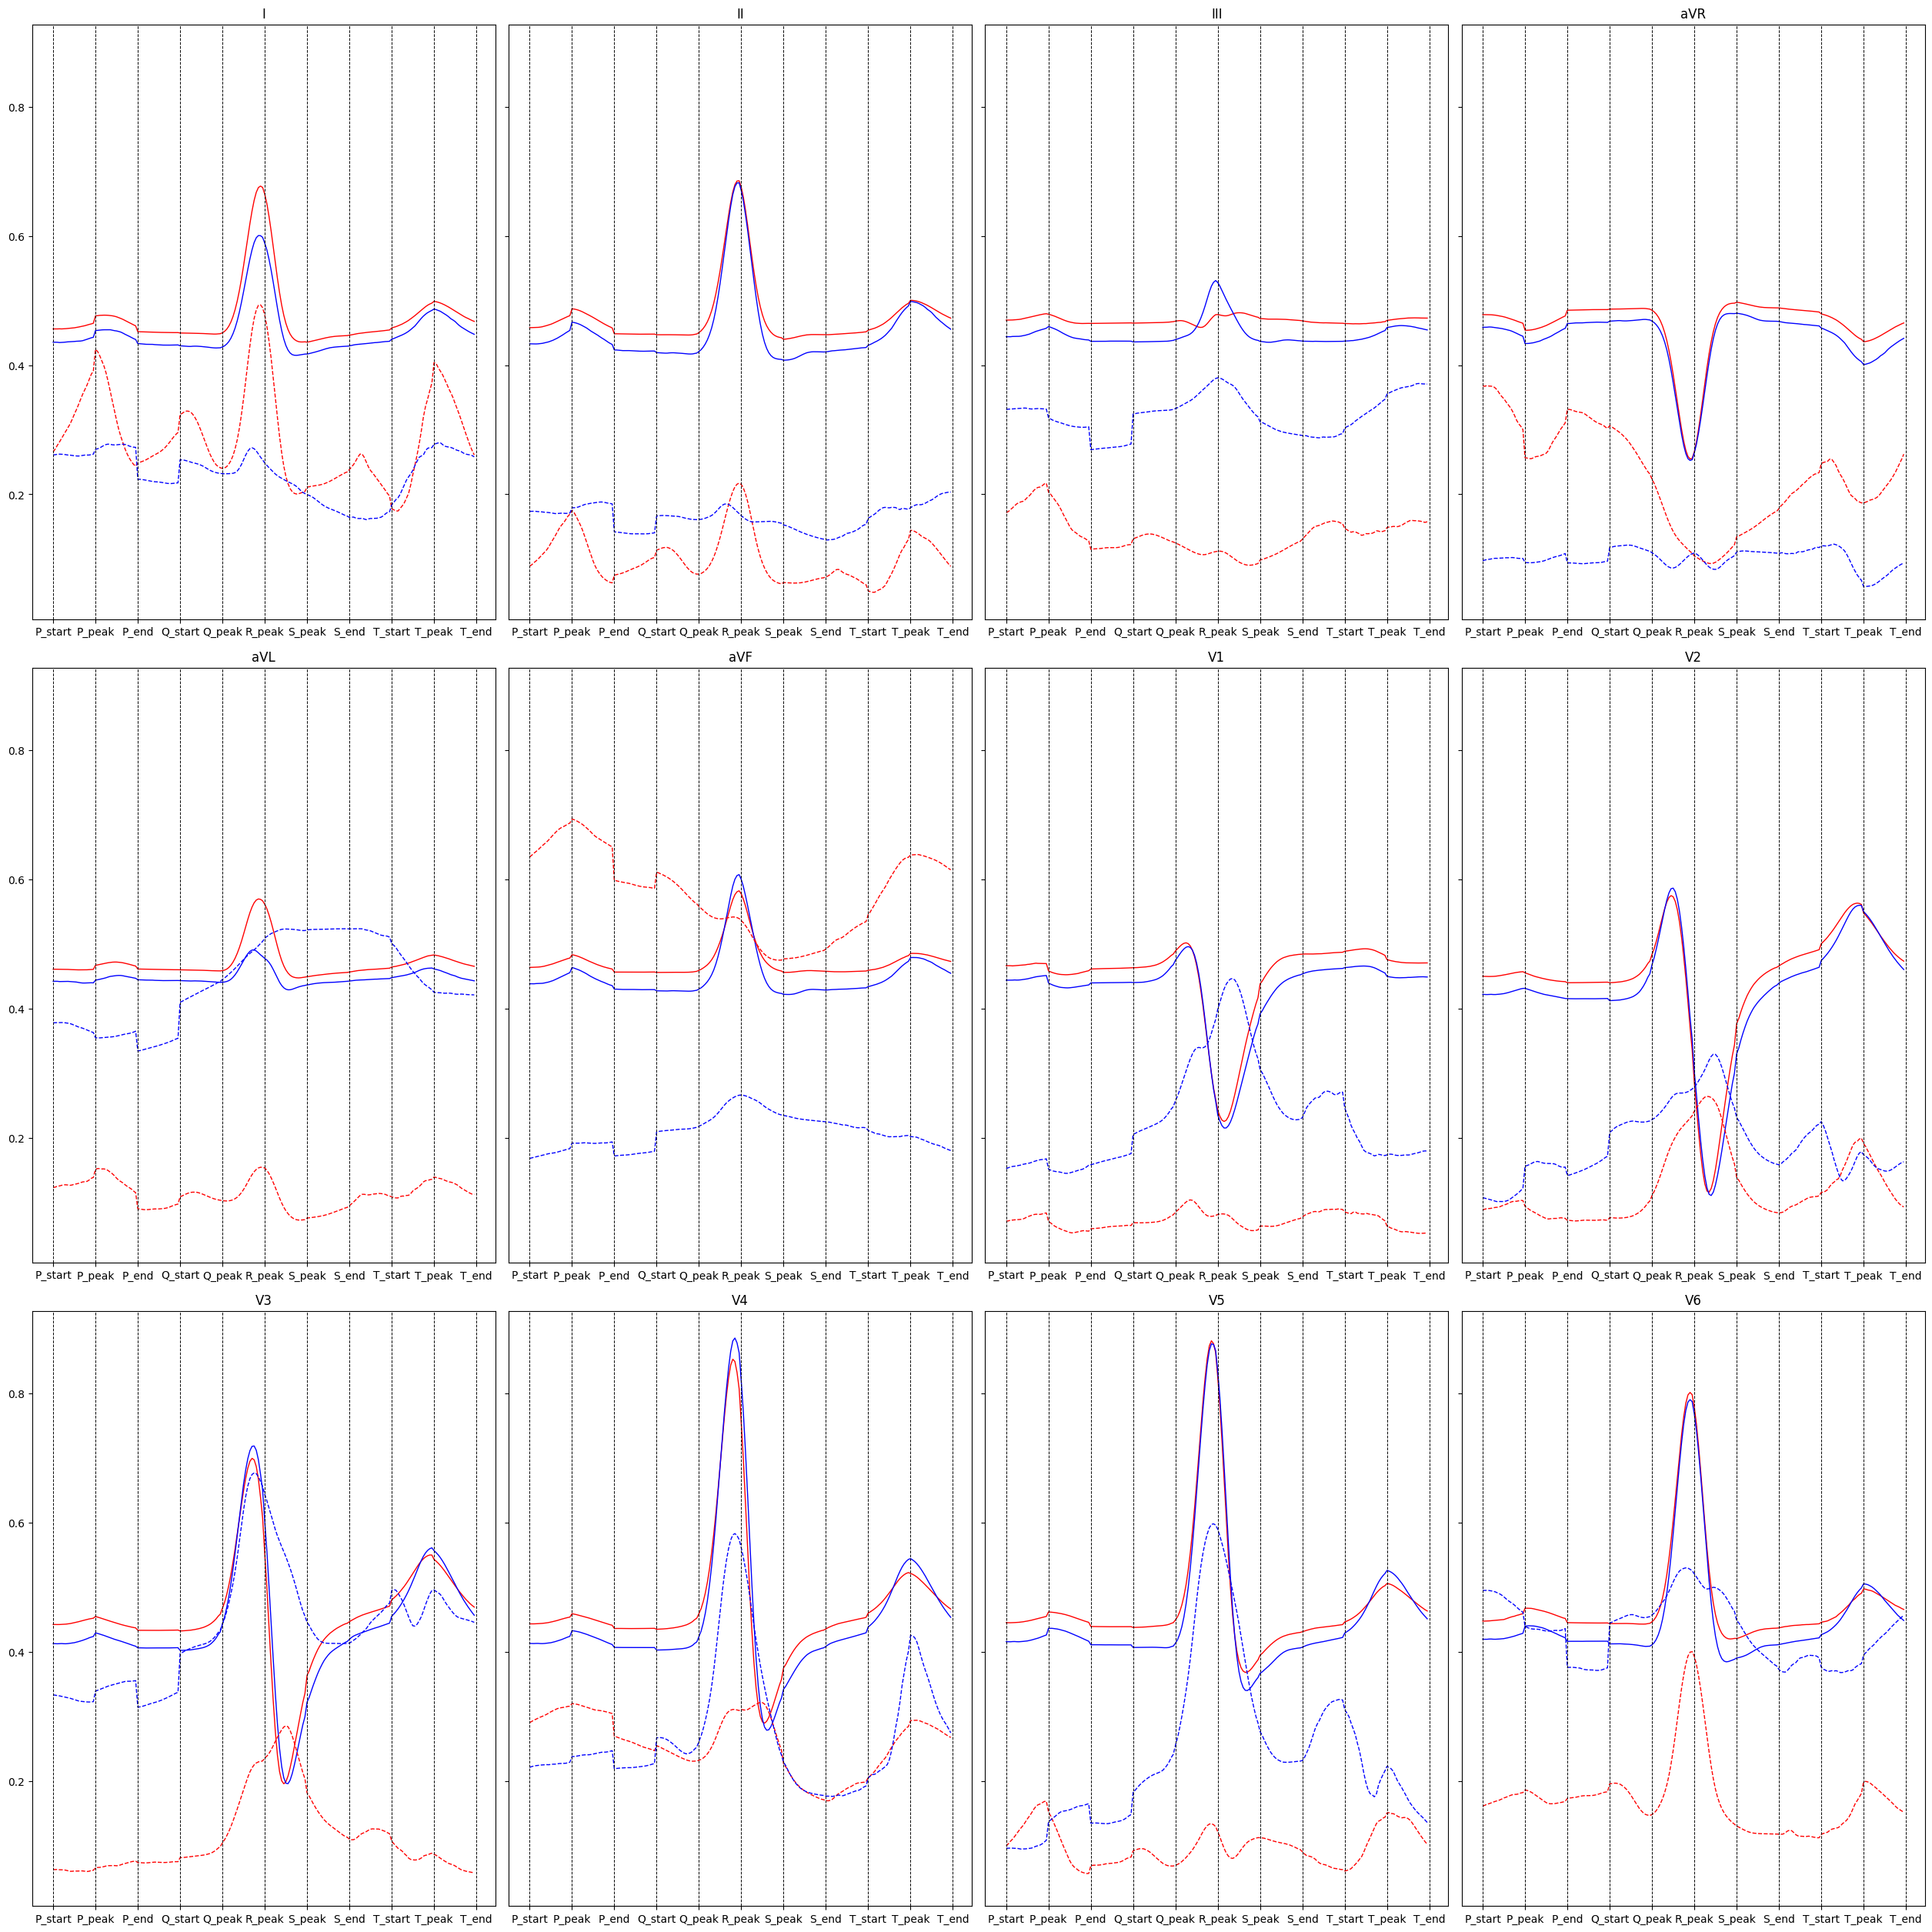

In [232]:
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
xticks_list = list(np.arange(0,len(select_list)*segement_num,segement_num))

fig, axs = plt.subplots(nrows=3, ncols=4,sharey=True,figsize=(25,25), constrained_layout=True,dpi =100)

HTN_colors = ECGplot.color_map(((HTN_important_values.reshape([12,-1]))), 'autumn')#相当于归一化
NHTN_colors = ECGplot.color_map(((NHTN_important_values.reshape([12,-1]))), 'YlGnBu')#相当于归一化
for i,ax in enumerate(axs.flat):  # type: ignore
    HTN_plot_y = np.array(HTN_ECG_values[:,i,:].flatten())
    HTN_colors_z = np.array(HTN_important_values[:,i,:].flatten())
    NHTN_plot_y = np.array(NHTN_ECG_values[:,i,:].flatten())
    NHTN_colors_z = np.array(NHTN_important_values[:,i,:].flatten())    
    t = np.arange(0,HTN_plot_y.shape[0]) #  
    ax.plot(t, (HTN_plot_y), lw=1,color='r')
    ax.plot(t, (NHTN_plot_y), lw=1,color='b')
    
    ax.plot(t, (HTN_colors_z), lw=1,color='r',ls='dashed')
    ax.plot(t, (NHTN_colors_z), lw=1,color='b',ls='dashed') 
    
    for j in range(len(select_list)):
        ax.axvline(x=int(xticks_list[j]),ls='dashed',lw=0.7,color='k')
        
    ax.set_xticks(xticks_list) # 设置刻度
    ax.set_xticklabels(select_list)
    ax.set_title(lead_index[i])
    # for k in t:
    #     ax.axvline(x=k,alpha=0.2,color=HTN_colors[i,k]) #第i导联 第j个时间点的importance value
    #     ax.axvline(x=k,alpha=0.2,color=NHTN_colors[i,k]) #第i导联 第j个时间点的importance value